### 1.Introduction
The name of the competition is [predict future sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales). We were given some daily transaction data of the previous 33 months and other informations to predict the item sales count in the Novemenber of 2015. My final public score is 0.85573 which ranked 141 among all 10757 teams. 

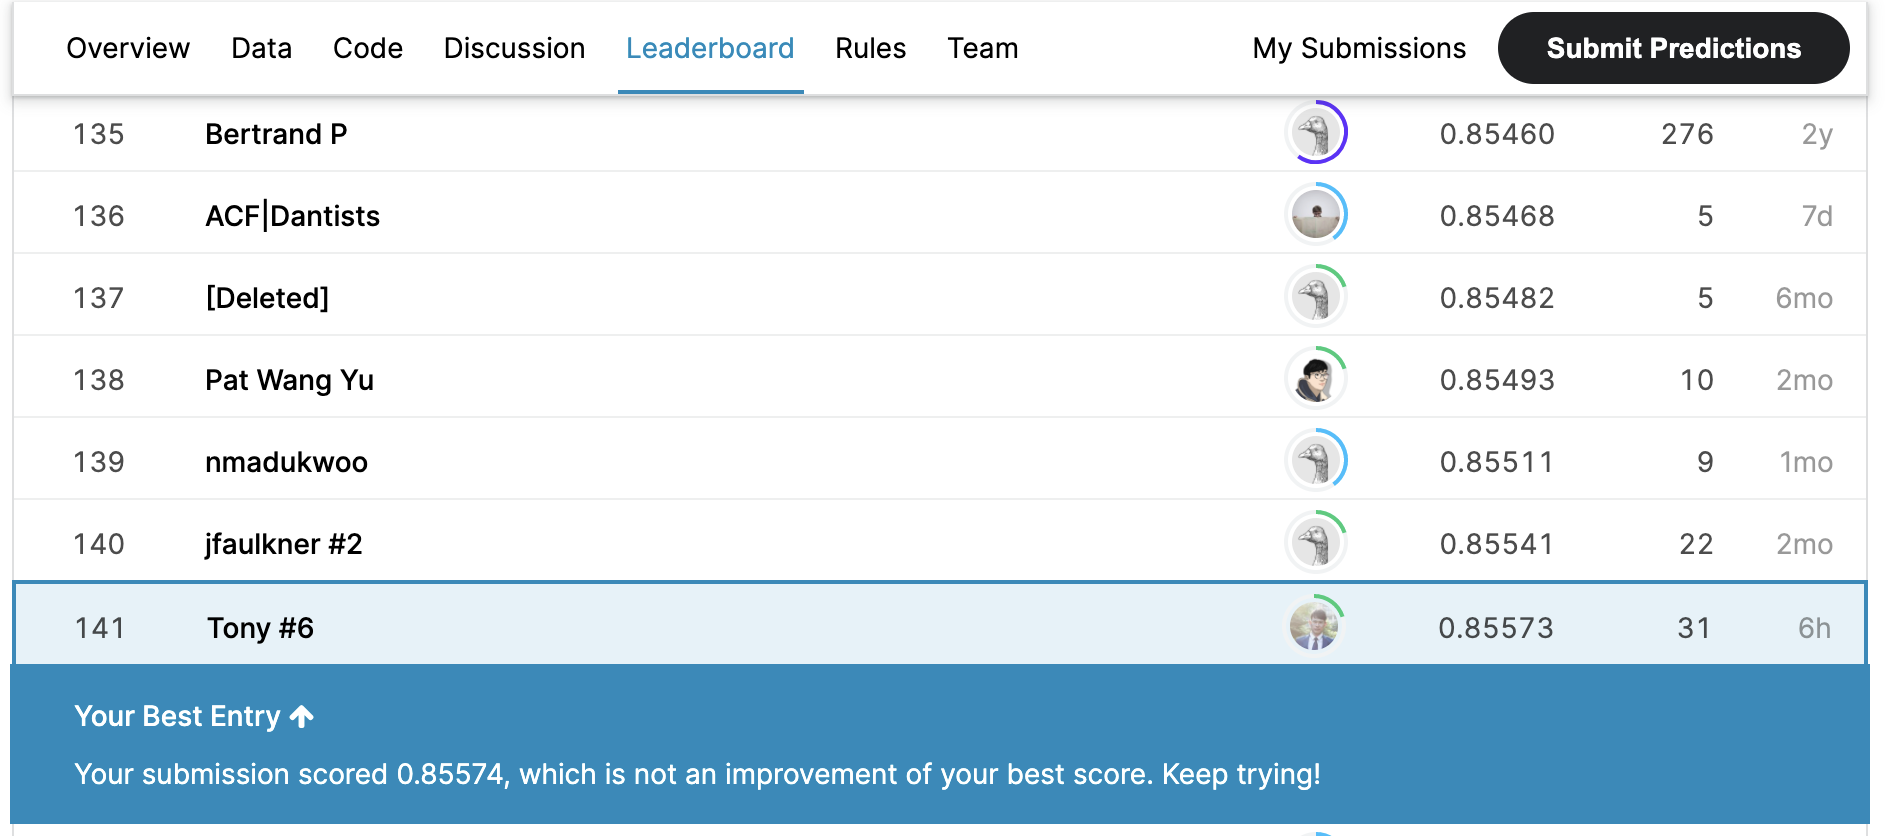

Since my goal of participating in this competition is to learn, I got some ideas from notebooks in the discussion forum which really helped me: 


 - General Feature engineering: https://www.kaggle.com/deepdivelm/feature-engineering-lightgbm-exploring-performance
 - Novel Feature engineering: https://www.kaggle.com/uladzimirkapeika/feature-engineering-lightgbm-top-1
 - Model stacking:  https://www.kaggle.com/dimitreoliveira/model-stacking-feature-engineering-and-eda

I tried out many methods to improve my score, though most of the methods did not improve the final public score, but there are a few which really improved the scores:


##### 1.Translating the item and shop names to english
   As the data set given to us is Russian, and i don't know russian at all. However, The information of the items and the categories are really helpful. Especially when predicting the item which has never been sailed before, the name of the item could bring us a big help. What's more, many helpful NLP libraries are in English, such us Word2Vec, translating to english could give us more help

##### 2.Adding the neighbour items sales
I build a raw tree model at first and analysis the importance of the features and found that the item-id is very important. Then I decideded to add the neighbour lag info to the dataset 

##### 3.Adding city country part
Each part of the country has different economy status. Adding this could help the model

### Main model

In [1]:
import pandas as pd
import numpy as np
from itertools import product
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import category_encoders as ce
import warnings
import lightgbm as lgb
import matplotlib.pyplot as plt
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time

#### Load the Data

The data is generated through the code:     all_data_generation.py, or you could load the data directly

In [2]:
df = pd.read_pickle('df_added_city_code_item_lag.pkl')

In [3]:
df.head()

,shop_id,item_id,date_block_num,item_cnt,first_sale_day,month,year,day_quality,category_id,item_name_first11,...,item_name_first11_12,item_name_first11_13,item_name_first11_14,city_code,city_coord_1,city_coord_2,country_part,item_cnt_lag_1_adv,item_cnt_lag_2_adv,item_cnt_lag_3_adv
0,2,27,0,1,2,1,0,4.38175,19,2,...,0,0,1,0,44.609764,40.100516,3,NaN,NaN,NaN
1,2,33,0,1,2,1,0,4.38175,37,1203,...,0,1,0,0,44.609764,40.100516,3,NaN,NaN,NaN
2,2,317,0,1,4,1,0,4.38175,45,52,...,0,1,1,0,44.609764,40.100516,3,NaN,NaN,NaN
3,2,438,0,1,19,1,0,4.38175,45,57,...,1,0,0,0,44.609764,40.100516,3,NaN,NaN,NaN
4,2,471,0,2,3,1,0,4.38175,49,51,...,1,0,1,0,44.609764,40.100516,3,NaN,NaN,NaN


In [7]:

def lag_feature_adv(df, lags, col):
    """
    Create lag futures for the original dataframe 
    param: df: input dataframe 
    param: lags: list of nums of months need to lag 
    param: col: the columns wanted to compute lag featrues
    return: orginal dataframe merged with the added lag vals
    """
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)+'_adv']
        shifted['date_block_num'] += i
        shifted['item_id'] -= 1
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)+'_adv'] = df[col+'_lag_'+str(i)+'_adv'].astype('float16')
    return df

In [8]:
def build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val)
    model = lgb.train(params=params, train_set=lgb_train, valid_sets=(lgb_train, lgb_val), verbose_eval=50,
                     categorical_feature=cat_features)
    return model

In [18]:
X_train,Y_train,X_valid,Y_valid, X_test = train_val_test_generation(df)

#### Run lgbm

 The parameter choosen here is the current best result of parameter tunning

In [16]:

params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'num_leaves': 1023,
    'min_data_in_leaf':10,
    'feature_fraction':0.75,
    'bagging_fraction':0.75,
    'learning_rate': 0.01,
    'num_rounds': 1000,
    'early_stopping_rounds': 50,
    'seed': 1
}
#designating the categorical features which should be focused on
cat_features = ['category_id','month','shop_id','shop_city']

lgb_model = build_lgb_model(params, X_train, X_valid, Y_train, Y_valid, cat_features)

#save model for later use
lgb_model.save_model('initial_lgb_model.txt')

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['category_id', 'month', 'shop_city', 'shop_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.684733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15061
[LightGBM] [Info] Number of data points in the train set: 7795360, number of used features: 162


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 0.312795
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.977829	valid_1's rmse: 0.892847
[100]	training's rmse: 0.836873	valid_1's rmse: 0.808096
[150]	training's rmse: 0.762484	valid_1's rmse: 0.77102
[200]	training's rmse: 0.719753	valid_1's rmse: 0.755576
[250]	training's rmse: 0.692217	valid_1's rmse: 0.749017
[350]	training's rmse: 0.657281	valid_1's rmse: 0.74391
[400]	training's rmse: 0.644478	valid_1's rmse: 0.743332
[500]	training's rmse: 0.624104	valid_1's rmse: 0.743002
[550]	training's rmse: 0.615713	valid_1's rmse: 0.742763
[600]	training's rmse: 0.60846	valid_1's rmse: 0.742583
[650]	training's rmse: 0.601823	valid_1's rmse: 0.742596
Early stopping, best iteration is:
[605]	training's rmse: 0.607753	valid_1's rmse: 0.742474


##### Help functions:
Below are the few helper functions to predict and analysis the model result

In [10]:
def val_pred(model,X_val):
    """
    Predict the y_val according to the model and the X_val
    param: model: trained model 
    param: X_val: X validation data 
    return: predicted y val
    """
    return model.predict(X_val)

In [11]:
def lgb_plot_feature_importance(lgb_model,num_features):
    """
    Plot feature importance for lgb model 
    param: lgb_model: lightgbm trained model 
    param: num_features: the  max num of features want to display
    """
    plt.figure(figsize=(50,30))
    lgb_model.plot_importance(lgb_model, max_num_features= num_features)
    plt.title("Featurertances")
    plt.show()

In [12]:
def model_performance_sc_plot(predictions, labels, title):
    """
    Plot the scatter plot of predicted val and real val ,exp: model_performance_sc_plot(lgbm_val_pred, y_val, 'Validation')
    param: predictions: the predictions
    param: real result of the labels 
    title: names want to show on the title graph
    """
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()

In [13]:
def create_submission_file(model,file_name):
    """
    Create submission file for the file name 
    param: file_name: file name want to submit 
    """
    submission = pd.read_csv('sample_submission.csv')
    submission['item_cnt_month'] = model.predict(X_test).clip(0,20)
    submission[['ID', 'item_cnt_month']].to_csv(file_name, index=False)
    

In [14]:
def train_val_test_generation(df):
    """
    Generate the dataframe from the train and val 
    param: df: the dataframe wants to generate ,note: the y_th column is 'item_cnt'!
    """
    data = df
    # the first two month can not be accounted since we use the lag of 2 
    X_train = data[(data.date_block_num < 33)&(data.date_block_num>1)].drop(['item_cnt'], axis=1)
    Y_train = data[(data.date_block_num < 33)&(data.date_block_num>1)]['item_cnt']
    X_valid = data[data.date_block_num == 33].drop(['item_cnt'], axis=1)
    Y_valid = data[data.date_block_num == 33]['item_cnt']
    X_test = data[data.date_block_num == 34].drop(['item_cnt'], axis=1)
    # Clip the y
    Y_train = Y_train.clip(0, 20)
    Y_valid = Y_valid.clip(0, 20)
    
    return X_train,Y_train,X_valid,Y_valid,X_test

### Other Methods

As parameter tunning is already the best, I tried other methods to improve the model. However, these methods did not improve the final score

#### Train on part

In [ ]:
After analysis

In [18]:
def generate_part_df(df):
    """
    Generate the important features 
    """
    # important features from shine app analysis 
    important_features2 = ["date_block_num","shop_city","item_cnt","item_cnt_lag1to12","item_cnt_all_shops_lag1","category_cnt_lag1","prev_days_on_sale","item_cnt_per_day_alltime","category_cnt_lag1to12","item_cnt_all_shops_diff","category_id","shop_id","category_cnt_lag2","item_cnt_sum_alltime","item_cnt_per_day_alltime_allshops","new_items_in_cat_lag1to12","category_cnt_all_shops_lag1","above_item_cnt_all_shops_lag1","item_age_without_shop_sale","first_sale_day","item_cnt_all_shops_lag1to12","same_name4catage_cnt","last_item_price","item_cnt_all_shops_lag2","shop_cnt_lag1to12","item_name_first11_age","month","category_cnt_all_shops_lag2","relative_price_item_block_lag1","item_age","russian_in_name","item_age_if_shop_sale",'item_cnt_lag_1_adv','item_cnt_lag_2_adv','country_part']
    df_part = df[important_features2]
    df_part =  df_part.fillna(0)
    return df_part 

In [19]:
df_part = generate_part_df(df)

In [39]:
def get_val_score(X_valid,Y_valid,model):
    """
    Get validation score 
    """
    Y_val_pred = model.predict(X_valid)
    return np.sqrt(mean_squared_error(Y_valid, Y_val_pred))
    

In [38]:
# Get the train, test , val data from the original dataframe 
X_train,Y_train,X_valid,Y_valid,X_test = train_val_test_generation(df)

In [35]:
#skip this cell if directly loading saved model 
params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'num_leaves': 1023,
    'min_data_in_leaf':10,
    'feature_fraction':0.75,
    'bagging_fraction':0.75,
    'learning_rate': 0.01,
    'num_rounds': 1000,
    'early_stopping_rounds': 50,
    'seed': 1
}
#designating the categorical features which should be focused on
cat_features = ['category_id','month','shop_id','shop_city']

lgb_model = build_lgb_model(params, X_train, X_valid, Y_train, Y_valid, cat_features)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['category_id', 'month', 'shop_city', 'shop_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.199178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5853
[LightGBM] [Info] Number of data points in the train set: 7795360, number of used features: 35


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 0.312795
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.991441	valid_1's rmse: 0.900879
[100]	training's rmse: 0.860086	valid_1's rmse: 0.820149
[150]	training's rmse: 0.790905	valid_1's rmse: 0.786265
[200]	training's rmse: 0.751475	valid_1's rmse: 0.770601
[250]	training's rmse: 0.726992	valid_1's rmse: 0.763977
[300]	training's rmse: 0.709	valid_1's rmse: 0.761409
[350]	training's rmse: 0.695085	valid_1's rmse: 0.760071
[400]	training's rmse: 0.68342	valid_1's rmse: 0.75982
Early stopping, best iteration is:
[384]	training's rmse: 0.686873	valid_1's rmse: 0.759745


In [37]:
create_submission_file(lgb_model,"sub_data_lgb_submission_1.csv")

In [37]:
# read the model from the files 
lgb_model = lgb.Booster(model_file='initial_lgb_model.txt')

In [54]:
# get the shop 12 data
df_shop_12 = df[df["shop_id"]==12]
df_shop_12.head()

,shop_id,item_id,date_block_num,item_cnt,first_sale_day,month,year,day_quality,category_id,item_name_first11,...,item_name_first11_12,item_name_first11_13,item_name_first11_14,city_code,city_coord_1,city_coord_2,country_part,item_cnt_lag_1_adv,item_cnt_lag_2_adv,item_cnt_lag_3_adv
45270,12,27,0,0,2,1,0,4.636029,19,2,...,0,0,1,7,0.0,0.0,0,NaN,NaN,NaN
45271,12,33,0,0,2,1,0,4.636029,37,1203,...,0,1,0,7,0.0,0.0,0,NaN,NaN,NaN
45272,12,317,0,0,4,1,0,4.636029,45,52,...,0,1,1,7,0.0,0.0,0,NaN,NaN,NaN
45273,12,438,0,0,19,1,0,4.636029,45,57,...,1,0,0,7,0.0,0.0,0,NaN,NaN,NaN
45274,12,471,0,1,3,1,0,4.636029,49,51,...,1,0,1,7,0.0,0.0,0,NaN,NaN,NaN


### Validation score analysis 

In [41]:
# get the category id =20 part 
df_cat_20 = df[df["category_id"] == 20]

In [42]:
# get the train and test frame 
X_cat_20_train,Y_cat_20_train,X_cat_20_valid,Y_cat_20_valid,X_cat_20_test = train_val_test_generation(df_cat_20)

In [48]:
# get the predidction score for cat 20
print(get_val_score(X_cat_20_valid,Y_cat_20_valid,lgb_model))

2.337765869348266


In [56]:
X_shop_12_train,Y_shop_12_train,X_shop_12_valid,Y_shop_12_valid,Y_shop_12_test = train_val_test_generation(df_shop_12)

In [58]:
print(get_val_score(X_shop_12_valid,Y_shop_12_valid,lgb_model))

0.8445612753949514


In [44]:
# Get the train, test , val data from the original dataframe 
X_train,Y_train,X_valid,Y_valid,X_test = train_val_test_generation(df)

In [45]:
print(get_val_score(X_valid,Y_valid,lgb_model))

0.74247453578402


In [61]:
# shop 55 analysis 
df_shop_55 = df[df["shop_id"]==55]

In [62]:
X_shop_55_train,Y_shop_55_train,X_shop_55_valid,Y_shop_55_valid,Y_shop_55_test = train_val_test_generation(df_shop_55)

In [63]:
print(get_val_score(X_shop_55_valid,Y_shop_55_valid,lgb_model))

0.9278387706053229


In [66]:
# other shops apart from shop12,shop55 
df_shop_others = df.loc[(df["shop_id"]!=55)&(df["shop_id"]!=12)]

In [67]:
len(df_shop_others)

8347625

In [69]:
print(get_val_score(X_shop_other_valid,Y_shop_other_valid,lgb_model))

0.7344914191457258


In [84]:
X_shop_other_test_predict["item_cnt"]=X_shop_other_test_predict["item_cnt"].clip(0,20)

In [92]:
X_shop_other_test_predict = X_shop_other_test_predict[["shop_id","item_id","item_cnt"]]

In [60]:
# use the shop 12 to build the model 
#skip this cell if directly loading saclipd model 
params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'num_leaves': 1023,
    'min_data_in_leaf':10,
    'feature_fraction':0.75,
    'bagging_fraction':0.75,
    'learning_rate': 0.01,
    'num_rounds': 1000,
    'early_stopping_rounds': 200,
    'seed': 1
}
#designating the categorical features which should be focused on
cat_features = ['category_id','month','shop_id','shop_city']

lgb_model_shop_12 = build_lgb_model(params, X_shop_12_train, X_shop_12_valid, Y_shop_12_train,Y_shop_12_valid, cat_features)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13217
[LightGBM] [Info] Number of data points in the train set: 199526, number of used features: 154
[LightGBM] [Info] Start training from score 0.201307
Training until validation scores don't improve for 200 rounds
[50]	training's rmse: 0.866377	valid_1's rmse: 0.916367
[100]	training's rmse: 0.691345	valid_1's rmse: 0.831901
[150]	training's rmse: 0.585102	valid_1's rmse: 0.816323
[200]	training's rmse: 0.514849	valid_1's rmse: 0.825385
[250]	training's rmse: 0.464439	valid_1's rmse: 0.842552
[300]	training's rmse: 0.425551	valid_1's rmse: 0.856501
Early stopping, best iteration is:
[146]	training's rmse: 0.591828	valid_1's rmse: 0.815579


In [78]:
X_shop_12_test_predict = Y_shop_12_test
X_shop_12_test_predict["item_cnt"] = lgb_model_shop_12.predict(Y_shop_12_test)

In [86]:
X_shop_12_test_predict["item_cnt"] = X_shop_12_test_predict["item_cnt"].clip(0,20)

In [90]:
X_shop_12_test_predict = X_shop_12_test_predict[["shop_id","item_id","item_cnt"]]

In [64]:
# use the shop 55 to build the model 
#skip this cell if directly loading saved model 
params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'num_leaves': 1023,
    'min_data_in_leaf':10,
    'feature_fraction':0.75,
    'bagging_fraction':0.75,
    'learning_rate': 0.01,
    'num_rounds': 1000,
    'early_stopping_rounds': 200,
    'seed': 1
}
#designating the categorical features which should be focused on
cat_features = ['category_id','month','shop_id','shop_city']

lgb_model_shop_55 = build_lgb_model(params, X_shop_55_train, X_shop_55_valid, Y_shop_55_train,Y_shop_55_valid, cat_features)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['category_id', 'month', 'shop_city', 'shop_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11775
[LightGBM] [Info] Number of data points in the train set: 184194, number of used features: 154
[LightGBM] [Info] Start training from score 0.203660
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	training's rmse: 0.892198	valid_1's rmse: 1.31093
[100]	training's rmse: 0.652877	valid_1's rmse: 1.10543
[150]	training's rmse: 0.508951	valid_1's rmse: 1.00974
[200]	training's rmse: 0.418954	valid_1's rmse: 0.965014
[250]	training's rmse: 0.356396	valid_1's rmse: 0.943227
[300]	training's rmse: 0.309654	valid_1's rmse: 0.931421
[350]	training's rmse: 0.273907	valid_1's rmse: 0.925611
[400]	training's rmse: 0.244464	valid_1's rmse: 0.920985
[450]	training's rmse: 0.219244	valid_1's rmse: 0.917237
[500]	training's rmse: 0.19766	valid_1's rmse: 0.915178
[550]	training's rmse: 0.179569	valid_1's rmse: 0.913572
[650]	training's rmse: 0.151046	valid_1's rmse: 0.913328
[700]	training's rmse: 0.13968	valid_1's rmse: 0.912889
[750]	training's rmse: 0.129765	valid_1'

### Random forest

In [55]:
rf_train_pred = rf_model.predict(X_train)
rf_val_pred = rf_model.predict(X_valid)
rf_test_pred = rf_model.predict(X_test)

In [63]:
rf_test_pred_frame = pd.DataFrame(rf_test_pred)

In [59]:
rf_val_pred_frame = pd.DataFrame(rf_val_pred)

In [64]:
rf_test_pred_frame.to_csv("prediction_models/rf_test_pred.csv")

In [62]:
rf_val_pred_frame.to_csv("prediction_models/rf_val_pred.csv")

In [57]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, rf_val_pred)))

Train rmse: 0.9052813195479051
Validation rmse: 0.8122150930240909


### Linear model

In [21]:
import pickle
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams

In [33]:
len(X_train),len(Y_train),len(X_valid),len(Y_valid)

(7795360, 7795360, 220920, 220920)

In [23]:
lr_train = X_train
lr_val = X_valid
lr_test = X_test

In [24]:
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

In [25]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

LinearRegression(n_jobs=-1)

In [26]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

In [30]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lr_val_pred)))

Train rmse: 0.962456230361414
Validation rmse: 0.8712979301614221


In [61]:
submited = pd.read_csv("initial_lgb_submission.csv")

In [26]:
test = pd.read_csv("test.csv")
test_submited = pd.merge(submission,test,on=["ID"],how='left')

In [27]:
item_10202_predicted = test_submited[test_submited["item_id"]==10202]

In [28]:
test_submited[test_submited["item_id"]==10202]["item_cnt_month"].mean()

6.677739371096677

For the item 10202 , it first occurs in month : 2015-10, and we had a low prediction on it ,the average sales is 14.7 in 2015-10, however, we predicted 6.67 as average for the final  

### Submit the result 

In [24]:
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f  shifted_result5.csv -m "base on the sub part of the data(34) cols"

100%|███████████████████████████████████████| 4.58M/4.58M [00:11<00:00, 425kB/s]
Successfully submitted to Predict Future Sales

### Summary

The main cause of the rmse in the current model is the new item, which the item occured in the test set but not in the train set. I tried some methods to avoid this, such as trainning separately, model stacking, unfortunately, this method does not work well for the current model